In [63]:
# https://www.kaggle.com/aladdinpersson/flickr8kimagescaptions
import numpy as np
import pandas as pd
import os 
import cv2
from glob import glob

In [64]:
images_dir =  "../input/flickr8kimagescaptions/flickr8k/images/"
images = glob(images_dir+'*.jpg')
print(images[:4])

['../input/flickr8kimagescaptions/flickr8k/images/3226254560_2f8ac147ea.jpg', '../input/flickr8kimagescaptions/flickr8k/images/214543992_ce6c0d9f9b.jpg', '../input/flickr8kimagescaptions/flickr8k/images/2366643786_9c9a830db8.jpg', '../input/flickr8kimagescaptions/flickr8k/images/3368819708_0bfa0808f8.jpg']


In [65]:
number_of_images = len(images)
print(f"the number of images is {number_of_images}")

the number of images is 8091


In [66]:
captions = pd.read_csv("../input/flickr8kimagescaptions/flickr8k/captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


A black dog and a spotted dog are fighting


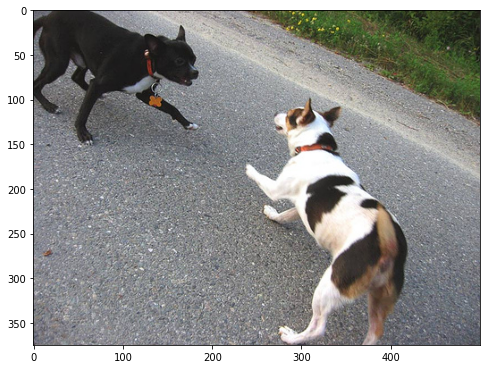

In [67]:
# now lets see some captions with their images
import matplotlib.pyplot as plt 
test_image = cv2.imread(images_dir + captions["image"][5])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(test_image)
print(captions["caption"][5])

****in this model we will use resnet 50 to extract the featchers and then we will use lstm and embedding for the captions 
after that we will combine the 2 results and pass it to a decoder(lstm and dense layer) to predict the next word it will be like this:****
<p>1- image_featchers + start --> next_word <p/>
<p>2- image_featchers + start + next_word --> 2nd_next_word<p/>
and repeat until the model predicts end or it arrives to the max length of the string

In [68]:
# here we import the resnet 50 model wich predict diffrent 1000 clases from an image
from keras.applications import ResNet50

In [69]:
resnet = ResNet50(include_top=True)

In [70]:
# here is the architecture of resnet it contains 50 diffrent layers of convolutions and maxpooling and dens 
# it accept only images with shape (224,224,3)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [71]:
# we are interested in the befor last layer it is there where all the featchers are
from keras.models import Model
print(resnet.layers[-2].output.shape)

(None, 2048)


In [72]:
# here we will take all the model exept the last layer
last_layer = resnet.layers[-2].output
modified_resnet = Model(inputs=resnet.input, outputs=last_layer)
modified_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [73]:
featchers_dict = {}
count  = 0
for img in images:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # we resize the image to be compatible with resnet
    image = cv2.resize(image, (224,224))
    # our model is expecting 4 dimentional input but image.shape is (224,224,3)
    image = image.reshape(1,224,224,3)
    # now lets predict
    prediction = modified_resnet.predict(image)
    # our predictions are in the form (1,2048)
    prediction = prediction.reshape(2048,)
    image_name = img.split("/")[-1]
    featchers_dict[image_name] = prediction 
    count += 1
    # since i dont have much computation power i will not use all the images 
    if count > 2048:
        break
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000


In [74]:
print(f'the total number of images is {len(featchers_dict)}')

the total number of images is 2049


<h1>lets start the text processing<h1/>

In [75]:
captions.iloc[0]['image']

'1000268201_693b08cb0e.jpg'

In [76]:
captions_dict = {}
for i in range(len(captions)):
    if captions.iloc[i]['image'] in featchers_dict:
        # i am doing this logic because every image has 5 captions
        if captions.iloc[i]['image'] not in captions_dict:
            captions_dict[captions.iloc[i]['image']] = [captions.iloc[i]['caption']]
        else:
            captions_dict[captions.iloc[i]['image']].append(captions.iloc[i]['caption'])

In [77]:
len(captions_dict)

2049

In [78]:
captions_dict['1002674143_1b742ab4b8.jpg']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


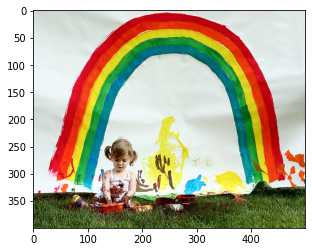

In [79]:
# lets verify the captions
test_img = cv2.imread(images_dir + '1002674143_1b742ab4b8.jpg') 
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
for i in range(5):
    print(captions_dict['1002674143_1b742ab4b8.jpg'][i])

In [80]:
# lets clean the text
# here we will leave the stop words and we will not limmetize the text becausse we need to generate text
# we will add startofstring and endofstring
import string
translator = str.maketrans('', '', string.punctuation)
def clean_text(text):
    cleaned = text.split()
    cleaned = [word.lower().translate(translator) for word in cleaned]
    cleaned = ' '.join(cleaned)
    cleaned = '<startofstr> '+ cleaned + ' <endofstr>'
    return cleaned 


In [81]:
s = "Hello i'm faycal and i love python !!."
print(clean_text(s))

<startofstr> hello im faycal and i love python  <endofstr>


In [82]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = clean_text(vv)

In [83]:
captions_dict['1002674143_1b742ab4b8.jpg']

['<startofstr> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <endofstr>',
 '<startofstr> a little girl is sitting in front of a large painted rainbow  <endofstr>',
 '<startofstr> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it  <endofstr>',
 '<startofstr> there is a girl with pigtails sitting in front of a rainbow painting  <endofstr>',
 '<startofstr> young girl with pigtails painting outside in the grass  <endofstr>']

In [84]:
# create vocab
all_captions = []
for k,v in captions_dict.items():
    for vv in v:
        all_captions.append(vv)
print(all_captions[:10])

['<startofstr> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <endofstr>', '<startofstr> a little girl is sitting in front of a large painted rainbow  <endofstr>', '<startofstr> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it  <endofstr>', '<startofstr> there is a girl with pigtails sitting in front of a rainbow painting  <endofstr>', '<startofstr> young girl with pigtails painting outside in the grass  <endofstr>', '<startofstr> a collage of one person climbing a cliff  <endofstr>', '<startofstr> a group of people are rock climbing on a rock climbing wall  <endofstr>', '<startofstr> a group of people climbing a rock while one man belays <endofstr>', '<startofstr> seven climbers are ascending a rock face whilst another man stands holding the rope  <endofstr>', '<startofstr> several climbers in a row are climbing the rock while the man in red watches and holds the line  <endofstr>']


In [85]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [86]:
tokenizer = Tokenizer(oov_token='<unknown>')
tokenizer.fit_on_texts(all_captions)

In [87]:
vocab_size = len(tokenizer.word_index) + 1
print(f'the vocabulary size is {vocab_size}')

the vocabulary size is 4716


In [88]:
all_captions_tokenized = tokenizer.texts_to_sequences(all_captions)
max_lenghth = 0
index = None
for i in range(len(all_captions_tokenized)):
    if (len(all_captions_tokenized[i]) > max_lenghth):
        max_lenghth = len(all_captions_tokenized[i])
        index = i
print(f"the maximum length of a sentence is {max_lenghth} in the index {index}")

the maximum length of a sentence is 34 in the index 3469


In [95]:
all_captions_tokenized[3469]

[3,
 36,
 54,
 15,
 11,
 8,
 89,
 6,
 97,
 67,
 15,
 11,
 10,
 2,
 16,
 2388,
 7,
 66,
 172,
 8,
 52,
 68,
 2,
 360,
 153,
 97,
 36,
 337,
 733,
 53,
 2,
 627,
 823,
 4]

In [93]:
for k, v in captions_dict.items():
    captions_dict[k] = tokenizer.texts_to_sequences(v)

In [94]:
captions_dict['1002674143_1b742ab4b8.jpg']

[[3,
  2,
  37,
  20,
  184,
  5,
  590,
  106,
  5,
  44,
  13,
  2,
  649,
  727,
  10,
  61,
  253,
  5,
  2,
  871,
  4],
 [3, 2, 37, 20, 8, 49, 5, 44, 13, 2, 62, 649, 727, 4],
 [3,
  2,
  60,
  20,
  5,
  6,
  40,
  116,
  10,
  2069,
  5,
  44,
  13,
  2,
  15,
  1692,
  10,
  2,
  727,
  7,
  141,
  4],
 [3, 179, 8, 2, 20, 10, 1001, 49, 5, 44, 13, 2, 727, 626, 4],
 [3, 27, 20, 10, 1001, 626, 89, 5, 6, 40, 4]]

In [114]:
# the input will be in the form of x1(the featchers of image), x2(the captions) the output is y 
from keras.utils import to_categorical

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=max_lenghth, padding='post')[0]
                out_seq = to_categorical(out_seq, num_classes=vocab_size)

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [115]:
# here is how to_categorical works
t = [1,2,3]
t = to_categorical(2, num_classes=4)
print(t)

[0. 0. 1. 0.]


In [116]:
X1, X2, y_out = generator(featchers_dict, captions_dict)

In [119]:
X1, X2, y_out = np.array(X1), np.array(X2), np.array(y_out)

In [120]:
X1.shape, X2.shape, y_out.shape

((121273, 2048), (121273, 34), (121273, 4716))

In [123]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate


In [126]:
# here we are going to create 2 models and thene concatenate theme into one
embedding_size = 128
max_len = max_lenghth

image_model = Sequential()
#  here the input is the resnet model prediction
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 34, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 128)           603648    
_________________________________________________________________
lstm (LSTM)                  (None, 34, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 128)           32896     
Total params: 1,030,784
Trai

In [128]:
model.fit([X1, X2], y_out, batch_size=256, epochs=50)

Epoch 1/50
474/474 [==============================] - 24s 41ms/step - loss: 5.6872 - accuracy: 0.1273
Epoch 2/50
474/474 [==============================] - 20s 42ms/step - loss: 5.2548 - accuracy: 0.1327
Epoch 3/50
474/474 [==============================] - 20s 42ms/step - loss: 4.7233 - accuracy: 0.1996
Epoch 4/50
474/474 [==============================] - 20s 41ms/step - loss: 4.4464 - accuracy: 0.2274
Epoch 5/50
474/474 [==============================] - 20s 41ms/step - loss: 4.1907 - accuracy: 0.2573
Epoch 6/50
474/474 [==============================] - 20s 42ms/step - loss: 3.9111 - accuracy: 0.2798
Epoch 7/50
474/474 [==============================] - 20s 41ms/step - loss: 3.7020 - accuracy: 0.2980
Epoch 8/50
474/474 [==============================] - 20s 42ms/step - loss: 3.5139 - accuracy: 0.3131
Epoch 9/50
474/474 [==============================] - 20s 41ms/step - loss: 3.3620 - accuracy: 0.3247
Epoch 10/50
474/474 [==============================] - 20s 41ms/step - loss: 3.213

In [129]:
model.fit([X1, X2], y_out, batch_size=256, epochs=60)

Epoch 1/60
474/474 [==============================] - 20s 41ms/step - loss: 0.9998 - accuracy: 0.6937
Epoch 2/60
474/474 [==============================] - 20s 42ms/step - loss: 0.9743 - accuracy: 0.7002
Epoch 3/60
474/474 [==============================] - 19s 41ms/step - loss: 0.9678 - accuracy: 0.7012
Epoch 4/60
474/474 [==============================] - 20s 41ms/step - loss: 0.9347 - accuracy: 0.7109
Epoch 5/60
474/474 [==============================] - 19s 41ms/step - loss: 0.9122 - accuracy: 0.7168
Epoch 6/60
474/474 [==============================] - 19s 41ms/step - loss: 0.9002 - accuracy: 0.7196
Epoch 7/60
474/474 [==============================] - 19s 41ms/step - loss: 0.8684 - accuracy: 0.7292
Epoch 8/60
474/474 [==============================] - 19s 41ms/step - loss: 0.8560 - accuracy: 0.7317
Epoch 9/60
474/474 [==============================] - 20s 41ms/step - loss: 0.8362 - accuracy: 0.7369
Epoch 10/60
474/474 [==============================] - 19s 41ms/step - loss: 0.817

In [130]:
model.save('model.h5')
model.save_weights('model.weights.h5')

In [131]:
all_captions = np.array(all_captions)
np.save("all_captions.npy",all_captions)

In [132]:
def getImage(x): 
    test_img_path = images[x]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

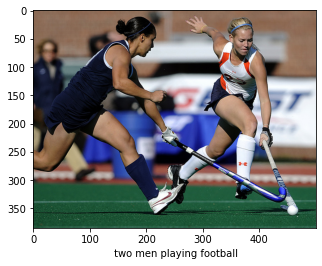

In [165]:
for i in range(1):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modified_resnet.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['<startofstr>']

    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = tokenizer.texts_to_sequences(text_inp)

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_lenghth)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        for k,v in tokenizer.word_index.items():
            if v == prediction:
                sampled_word = k
                break
                
                
        if sampled_word == 'endofstr':
            break
        caption = caption + ' ' + sampled_word
        
        text_inp[0] += ' ' + sampled_word
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [166]:
# its doing pretty well

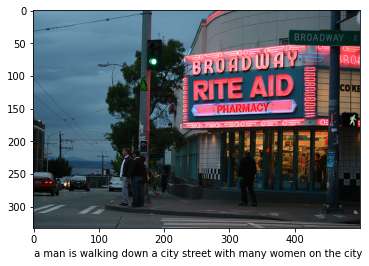

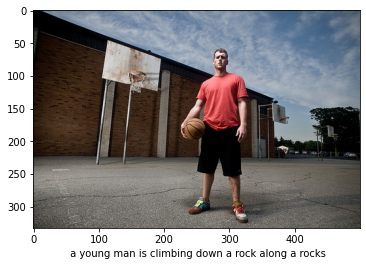

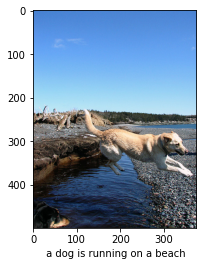

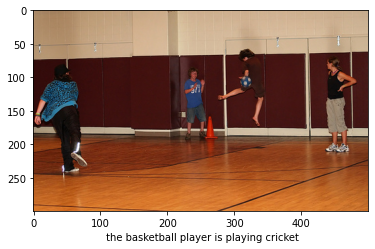

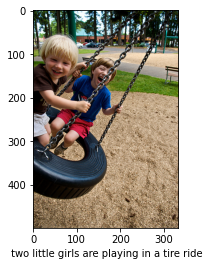

In [168]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modified_resnet.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['<startofstr>']

    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = tokenizer.texts_to_sequences(text_inp)

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_lenghth)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        for k,v in tokenizer.word_index.items():
            if v == prediction:
                sampled_word = k
                break
                
                
        if sampled_word == 'endofstr':
            break
        caption = caption + ' ' + sampled_word
        
        text_inp[0] += ' ' + sampled_word
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [ ]:
# with more training and more samples it will be much better